# Classification Model for all bike types

1) How well do the features of a bicycle determine the label?
2) How well can machine learning detect the type of bicycle?

I do not know yet what exactly I will say / present

## Imports

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.tree import DecisionTreeClassifier     #Depth-8 Decision Tree
from sklearn.neighbors import KNeighborsClassifier  #K-Neighbors
from sklearn.ensemble import RandomForestClassifier #Random Forest


from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn import set_config

In [3]:
#more imports
from sklearn.ensemble import AdaBoostClassifier        #AdaBoost
from sklearn.svm import SVC                            #Support Vector Clf.

from sklearn.gaussian_process import GaussianProcessClassifier     #Gaussian Pr. Clf.
from sklearn.neural_network import MLPClassifier                   #3-layer Neural Net, #6-Layer Neural Net
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV

In [4]:
#Read Data
data = pd.read_csv("Data/data_processed_cl.csv", index_col=0)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4511 entries, 0 to 4510
Columns: 1847 entries, SSSIDECX3 to SIZE_other
dtypes: float64(1415), int64(429), object(3)
memory usage: 63.6+ MB


There are 3 object columns (non-numeric). Let's check them out:

In [6]:
categorical_cols = data.select_dtypes(include="object").columns
print(len(list(categorical_cols)))
categorical_cols

3


Index(['BIKESTYLE', 'category', 'SIZE_in_text'], dtype='object')

In [7]:
data.BIKESTYLE.value_counts()

ROAD          1856
MTB            616
TRACK          470
OTHER          315
DIRT_JUMP      293
TOURING        201
CYCLOCROSS     151
POLO           128
TIMETRIAL       89
BMX             86
COMMUTER        75
CITY            72
CRUISER         42
HYBRID          39
TRIALS          35
GRAVEL          19
CARGO           14
CHILDRENS       10
Name: BIKESTYLE, dtype: int64

Ah, 
* `BIKESTYLE` and  `category` are my label columns (one at a time) and 
* `SIZE_text` is for ordinal encoding

## Splitting with label = `BIKESTYLE`

In [8]:
y_1 = data.pop("category")
y_2 = data.pop("BIKESTYLE")

In [9]:
X = data 

In [24]:
# Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_2, test_size=0.2, random_state=31416)

## Preprocessor Pipeline

In [25]:
# Select categorical and numerical columns
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()


In [26]:

# Numerical Pipeline, only with the SimpleImputer(strategy="mean") and MinMaxScaler
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="constant"),   #strategy="constant"
    MinMaxScaler()
)


In [27]:
# Categorical Pipeline

# # # i. Defining the categorical encoder
ordinal_col_names = ['SIZE_text'] 

ordinal_cols = X_cat.columns.get_indexer(ordinal_col_names)
#onehot_cols = X_cat.columns.get_indexer(list(set(X_cat) - set(ordinal_col_names)))


# # # ii. Defining values for Ordinal Encoding
SIZE_text = ["0", "xs", "s", "m", "l", "xl", "xxl", "xxxl"]

ordinal_cats_list = [SIZE_text]

# # # iii. Defining the ColumnTransformer with 2 branches: ordinal & onehot (categorical encoder)
categorical_encoder = ColumnTransformer(
    transformers=[
        ("cat_ordinal", OrdinalEncoder(categories=ordinal_cats_list), ordinal_cols),
#        ("cat_onehot", OneHotEncoder(handle_unknown="ignore"), onehot_cols),
    ]
)

# # # iv. Categorical pipeline = "NA" imputer + categorical encoder
categoric_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="NA"),
                                 categorical_encoder
                                )


In [28]:

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categoric_pipe, X_cat.columns),
    ]
)

## Preparing the models to be used

In [35]:
def get_model_and_params(model_name, param_grid):
    if model_name == "rforest":
        model = RandomForestClassifier(random_state=123)
        param_grid.update({"randomforestclassifier__warm_start": [True, False],
                "randomforestclassifier__n_estimators": [100, 200],
                "randomforestclassifier__max_depth": range(2, 14),
                "randomforestclassifier__min_samples_leaf": range(2, 10),
                "randomforestclassifier__criterion":["gini", "entropy"]})
    elif model_name == "knn":
        model = KNeighborsClassifier()
        param_grid.update({"kneighborsclassifier__n_neighbors": range(2, 50),
                "kneighborsclassifier__weights": ["uniform", "distance"]})
    elif model_name == "dt":
        model = DecisionTreeClassifier(random_state=123)
        param_grid.update({"decisiontreeclassifier__max_depth": range(2, 14),
                "decisiontreeclassifier__min_samples_leaf": range(2, 12),
#               "decisiontreeclassifier__min_samples_split": range(3, 40, 2),
                "decisiontreeclassifier__criterion":["gini", "entropy"]})
    elif model_name == "Ada":
        model = AdaBoostClassifier()
        param_grid.update({#"adaboostclassifiert__estimator": [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)],
                "adaboostclassifier__n_estimators": [50, 80],
                "adaboostclassifier__learning_rate": [0.5, 1.0, 1.5, 2.0, 2.5]})
    #elif model_name == "SVC": # runtime too long. Stopped after 2 hours 
    #    model = SVC()
    #    param_grid.update({"svc__kernel": ["linear", "poly", "rbf", "sigmoid"],
    #            "svc__class_weight": ["balanced", "None"]})
    elif model_name == "GaussPrC":
        model = GaussianProcessClassifier(1.0 * RBF(1.0))
        param_grid.update({"gaussianprocessclassifier__multi_class": ["one_vs_rest", "one_vs_one"]})
    elif model_name == "mlp":
        model = MLPClassifier()
        param_grid.update({"mlpclassifier__hidden_layer_sizes": [(200), (200, 200, 200)],
            "mlpclassifier__max_iter": [3000, 5000]})

    return model, param_grid


## Build evaluation function for several models

In [36]:
def evaluate_models(list_of_models, param_grid_preproc):
    score_new = {
        "model": [],
        "test_acc_score": [],
        "train_acc_score": [],
        "best_score_of_CV": [],
        "best_params": []
    }
    param_grid = {}
    
    for i in list_of_models:
        #reset values to be empty : 
        model = ""
        param_grid.clear()
        param_grid = param_grid_preproc

        # # # # it would nice if I make this into a function get_model_and_params
        model, param_grid = get_model_and_params(i, param_grid)

        #create the full_pipeline
        full_pipe = make_pipeline(preprocessor, 
                          StandardScaler(with_mean=False),
                          model
                             )

        # define cross validation
        search = RandomizedSearchCV(full_pipe,
                      param_grid,
                      cv=10,
                      verbose=1,
                      scoring="accuracy",
                      n_jobs=-2, 
                      n_iter=5,
                      random_state=123
                    )                             

        # fit
        search.fit(X_train, y_train)
        print(search.best_params_)

        score_new["model"].append(i)

        ### testing accuracy
        y_test_pred = search.predict(X_test)
        acc_test = accuracy_score(y_test, y_test_pred)
        score_new["test_acc_score"].append(acc_test)

        #get score of TRAIN-Data (overfitting?)
        y_train_pred = search.predict(X_train)
        acc_train = accuracy_score(y_train, y_train_pred)
        score_new["train_acc_score"].append(acc_train)

        # keep scores of model (optional)
        score_new["best_score_of_CV"].append(search.best_score_)
        score_new["best_params"].append(search.best_params_)

        # confusion matrix
        conf = confusion_matrix(y_test, y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf,
                                    display_labels=search.classes_)
        disp.plot()
        plt.show()

        #how do I use set_palette()
        #change plt.show() to sns.show()
        #How to set the palette to have the colors of my presentation?

        print(i, model)
        print(pd.DataFrame(conf))
        print("end")
    return pd.DataFrame(score_new)



## Running the pipeline for several models

In [47]:
# set models, pass param_grid for preprocessor-pipeline
list_of_models =  ["mlp"] #["rforest", "knn", "dt"] # , , "knn", "dt", "mlp", "rforest", "knn", "dt", "GaussPrC", "mlp" "SVC" "Ada", , "mlp"

param_grid_preproc = {}

score_new = evaluate_models(list_of_models, param_grid_preproc)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


/Users/liane/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/liane/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


KeyboardInterrupt: 

In [56]:
#try the MLP without cross validation:
#model = MLPClassifier(hidden_layer_sizes = (200, 200, 200), max_iter = 3000) #--> acc_test of 68,9%

#try Gaussian Process without CV
model = model = GaussianProcessClassifier(1.0 * RBF(1.0), multi_class="one_vs_rest", random_state=123)

#create the full_pipeline
full_pipe = make_pipeline(preprocessor, 
                          StandardScaler(with_mean=False),
                          model
                             )
full_pipe.fit(X_train, y_train)


KeyboardInterrupt: 

In [53]:
### testing accuracy
y_test_pred = full_pipe.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
acc_test

0.6677740863787376

## Keep the scores

In [38]:
#Set to Initialize = True when you want to start over.
initialize_all_scores = False

if initialize_all_scores == True:
    score_all = {
        "model": [], 
        "test_acc_score" : [],
        "train_acc_score" : [],
        "best_params": [],
        "best_score_of_CV": [],
        "dataset": [],
        "preprocessing": [],
    }
    score_all = pd.DataFrame(score_all)

In [39]:
#description of the current round
dataset = "processed_cl,18labels" 
#"reduced,18labels"   
# #"reduced,19labels"

preprocessing = "split_0.8_to_0.2,_10fold_5times_CV,random_state_added,numerical_and_ordinalencoding_SIZE_in_text,SimpleImputer,StandardScaler"

#"split_0.8_to_0.2,5fold_5times_CV,numerical_and_ordinalencoding_SIZE_in_text,SimpleImputer,StandardScaler"
#"split_0.66_to_0.33,numerical_and_ordinalencoding_SIZE_in_text,SimpleImputer,StandardScaler" 
# #"only_numeric_cols,SimpleImputer_Mean"  
# #"all_columns,SimpleImputer_Mean,OneHot"

score_new["dataset"] = dataset
score_new["preprocessing"] = preprocessing

In [40]:
score_all = pd.concat([score_all, score_new], ignore_index=True)
score_all

,model,test_acc_score,train_acc_score,best_params,best_score_of_CV,dataset,preprocessing
0,rforest,0.693083,0.786896,"{'randomforestclassifier__warm_start': True, '...",0.691265,"processed_cl,18labels","split_0.66_to_0.33,numerical_and_ordinalencodi..."
1,knn,0.558093,1.000000,"{'kneighborsclassifier__weights': 'distance', ...",0.555256,"processed_cl,18labels","split_0.66_to_0.33,numerical_and_ordinalencodi..."
2,dt,0.638012,0.770351,{'decisiontreeclassifier__min_samples_leaf': 1...,0.659496,"processed_cl,18labels","split_0.66_to_0.33,numerical_and_ordinalencodi..."
3,rforest,0.687708,0.771064,"{'randomforestclassifier__warm_start': True, '...",0.693179,"processed_cl,18labels","split_0.8_to_0.2,5fold_5times_CV,numerical_and..."
4,knn,0.585825,0.779379,"{'kneighborsclassifier__weights': 'uniform', '...",0.574000,"processed_cl,18labels","split_0.8_to_0.2,5fold_5times_CV,numerical_and..."
5,dt,0.650055,0.724778,{'decisiontreeclassifier__min_samples_leaf': 1...,0.649380,"processed_cl,18labels","split_0.8_to_0.2,5fold_5times_CV,numerical_and..."
6,rforest,0.723145,0.868902,"{'randomforestclassifier__warm_start': True, '...",0.732535,"processed_cl,18labels","split_0.8_to_0.2,_10fold_5times_CV,random_stat..."
7,knn,0.636766,1.000000,"{'kneighborsclassifier__weights': 'distance', ...",0.628876,"processed_cl,18labels","split_0.8_to_0.2,_10fold_5times_CV,random_stat..."
8,dt,0.646733,0.756652,{'decisiontreeclassifier__min_samples_leaf': 4...,0.666574,"processed_cl,18labels","split_0.8_to_0.2,_10fold_5times_CV,random_stat..."


With a 0.66/0.33 split = 3000 /4500 split:
* 69% accurace with my RandomForest model / cleaned dataset
* 67% accuracy with the author's RandomForest model

With a 0.8/0.2 split
* 72% accuracy of RandomForest 

## Getting features of decision_tree

## Explore a single model and get feature names out

In [44]:
def evaluate_model(model_name, param_grid_preproc):
    score_new = {
        "model": [],
        "test_acc_score": [],
        "train_acc_score": [],
        "best_score_of_CV": [],
        "best_params": []
    }
    param_grid = {}
    

    #reset values to be empty : 
    param_grid = param_grid_preproc

    # # # # it would nice if I make this into a function get_model_and_params
    model, param_grid = get_model_and_params(model_name, param_grid)

    #create the full_pipeline
    full_pipe = make_pipeline(preprocessor, 
                          StandardScaler(with_mean=False),
                          model
                             )

    # define cross validation
    search = RandomizedSearchCV(full_pipe,
                      param_grid,
                      cv=10,
                      verbose=1,
                      scoring="accuracy",
                      n_jobs=-2, 
                      n_iter=5
                    )                             

    # fit
    search.fit(X_train, y_train)
    print(search.best_params_)

    score_new["model"].append(model_name)

    ### testing accuracy
    y_test_pred = search.predict(X_test)
    acc_test = accuracy_score(y_test, y_test_pred)
    score_new["test_acc_score"].append(acc_test)

    #get score of TRAIN-Data (overfitting?)
    y_train_pred = search.predict(X_train)
    acc_train = accuracy_score(y_train, y_train_pred)
    score_new["train_acc_score"].append(acc_train)

    # keep scores of model (optional)
    score_new["best_score_of_CV"].append(search.best_score_)
    score_new["best_params"].append(search.best_params_)

    # confusion matrix
    conf = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf,
                                    display_labels=search.classes_)
    disp.plot()
    plt.show()

        #how do I use set_palette()
        #change plt.show() to sns.show()
        #How to set the palette to have the colors of my presentation?

    print(pd.DataFrame(conf))
    print("end")
    return pd.DataFrame(score_new), search

#### Set parameters (model_name)

In [45]:
# Call the function, evaluate one model, and get the object "search"
#model_name = "dt"           # Decision Tree
model_name = "rforest"     # Random Forest

model, param_grid = get_model_and_params(model_name=model_name, param_grid={})
model_classifier_name = type(model).__name__.lower()
model_classifier_name

'randomforestclassifier'

Fitting 10 folds for each of 5 candidates, totalling 50 fits


/Users/liane/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


{'randomforestclassifier__warm_start': True, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 9, 'randomforestclassifier__criterion': 'gini'}


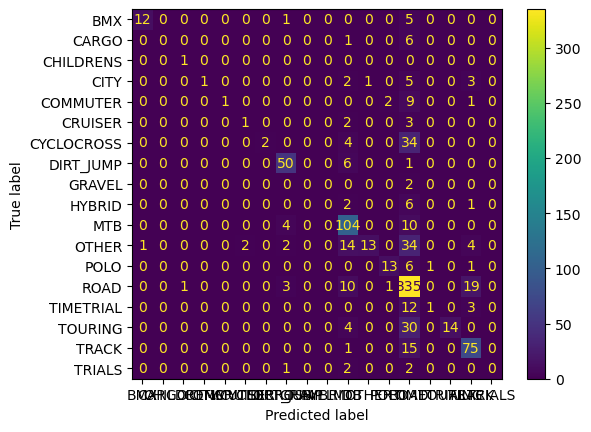

    0   1   2   3   4   5   6   7   8   9    10  11  12   13  14  15  16  17
0   12   0   0   0   0   0   0   1   0   0    0   0   0    5   0   0   0   0
1    0   0   0   0   0   0   0   0   0   0    1   0   0    6   0   0   0   0
2    0   0   1   0   0   0   0   0   0   0    0   0   0    0   0   0   0   0
3    0   0   0   1   0   0   0   0   0   0    2   1   0    5   0   0   3   0
4    0   0   0   0   1   0   0   0   0   0    0   0   2    9   0   0   1   0
5    0   0   0   0   0   1   0   0   0   0    2   0   0    3   0   0   0   0
6    0   0   0   0   0   0   2   0   0   0    4   0   0   34   0   0   0   0
7    0   0   0   0   0   0   0  50   0   0    6   0   0    1   0   0   0   0
8    0   0   0   0   0   0   0   0   0   0    0   0   0    2   0   0   0   0
9    0   0   0   0   0   0   0   0   0   0    2   0   0    6   0   0   1   0
10   0   0   0   0   0   0   0   4   0   0  104   0   0   10   0   0   0   0
11   1   0   0   0   0   2   0   2   0   0   14  13   0   34   0   0   4   0

In [46]:
# fit and predict for one model
score_single_model, search = evaluate_model(model_name = model_name, param_grid_preproc= {})

### Let's save the column names

In [ ]:
# save feature names for later use
feature_names = np.array(X.columns)
feature_names


array(['SSSIDECX3', 'SSSIDECX2', 'SSSIDECX1', ..., 'SIZE_in_inch',
       'SIZE_in_text', 'SIZE_other'], dtype=object)

In [ ]:
print(len(feature_names)) # length 1 --> we need to transpose it!
feature_names = feature_names.reshape(-1, 1)  
feature_names

1845


array([['SSSIDECX3'],
       ['SSSIDECX2'],
       ['SSSIDECX1'],
       ...,
       ['SIZE_in_inch'],
       ['SIZE_in_text'],
       ['SIZE_other']], dtype=object)

In [ ]:
# there are brakets in brakets, we need to flatten it
feature_names = feature_names.flatten()
print(len(feature_names), feature_names)
# --> now it looks good!

1845 ['SSSIDECX3' 'SSSIDECX2' 'SSSIDECX1' ... 'SIZE_in_inch' 'SIZE_in_text'
 'SIZE_other']


### Now we need to access the model

In [ ]:
# access the DT model in the pipe
#  --> Does not work here, because I do not have the pipe-object
# which position?
# full_pipe.steps[2]

In [ ]:
# access the model via the search
model = search.best_estimator_.named_steps[model_classifier_name]
importances = model.feature_importances_
importances

array([1.42396373e-03, 8.94019477e-04, 1.44186518e-03, ...,
       2.66713694e-04, 2.00627610e-05, 2.39608580e-04])

In [ ]:
#both need to be the same length --> YES!
print(len(importances), len(feature_names)) 

1845 1845


In [ ]:
features_df = {
    "columns": feature_names,
    "importance": importances}

features_df = pd.DataFrame(features_df)

In [ ]:
features_df = features_df.sort_values("importance", ascending = False).head(10)
features_df
# the model was so good because there were two columns still in there: "PERCENT", "COUNT"

,columns,importance
1040,Teeth on chainring 0,0.028703
1206,RDBSD,0.021942
1784,Handlebar style OHCLASS: 0,0.020609
768,CS textfield,0.020594
1207,FDBSD,0.020481
1205,FDERD,0.019444
1785,Handlebar style OHCLASS: 1,0.017893
1576,Fork type OHCLASS: 1,0.017483
250,Dropout spacing,0.016615
1037,DERAILLEUR_HANGER,0.016552


In [ ]:
# RESULTS FOR RANDOM FOREST
#   	columns	                    importance
#1040	Teeth on chainring 0	    0.028703        Number of teeth on chainring 0 (same as DT = #1)
#1206	RDBSD	                    0.021942        ...                         (also in DT #8 , here #2)
#1784	Handlebar style OHCLASS: 0	0.020609        ...                         (also in DT #10, here #3)
#768	CS textfield	            0.020594        ... some                    (also in DT #7 , here #4)
#1207	FDBSD	                    0.020481        ... more
#1205	FDERD	                    0.019444        ... columns
#1785	Handlebar style OHCLASS: 1	0.017893        ... in between
#1576	Fork type OHCLASS: 1	    0.017483        ...                         (also in DT #4 , here #8)
#250	Dropout spacing	            0.016615        ...
#1037	DERAILLEUR_HANGER	        0.016552        Schaltaufhängung -          (also in DT #2 , here #10) same importance!


#RESULTS FOR DECISION TREE
#   	columns	                    importance
#1040	Teeth on chainring 0	    0.236933        Number of teeth on chainring 0 (Anzahl Zähle auf Kettenblatt 0)
#1037	DERAILLEUR_HANGER	        0.169137        Schaltaufhängung - The hanger which fixes the gear shift to the frame at the rear wheel
#1128	Saddle height	            0.095040        
#1576	Fork type OHCLASS: 1	    0.079594        
#1205	FDERD	                    0.056719
#465	Wheel diameter front	    0.050802
#768	CS textfield	            0.041495
#1206	RDBSD	                    0.035787
#532	FORK0R	                    0.031524
#1784	Handlebar style OHCLASS: 0	0.026295

In [ ]:
# add column importance in %

# make the image smaller

# change labels

# change colour code

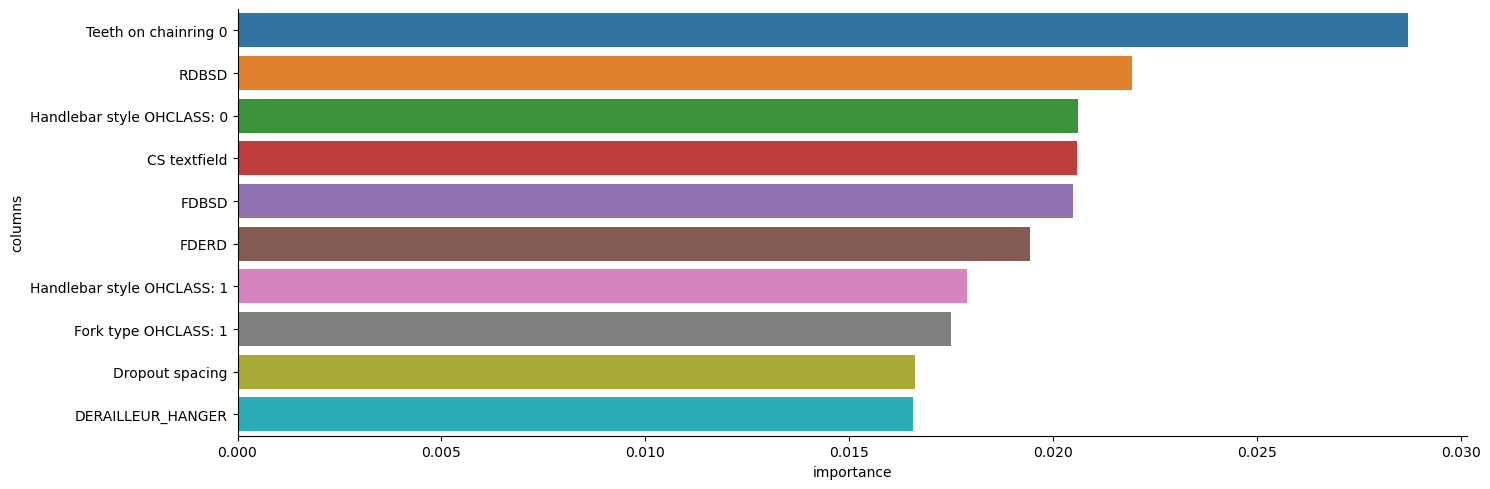

In [ ]:
import seaborn as sns
sns.catplot(data=features_df.head(10), 
            kind="bar",
            x="importance", 
            y="columns",
            aspect = 3,
            estimator = sum
            );